已连接到 torch_env (Python 3.13.2)

In [ ]:
"""
Müller-Brown势能神经网络回归模型对比
"""

# 导入必要库
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from typing import Tuple, Dict, Any
import time
import platform
import os
import datetime
import json

# 设置中文字体（根据操作系统设置合适的字体）
if platform.system() == "Windows":
    plt.rcParams["font.sans-serif"] = ["Microsoft YaHei", "SimHei"]  # 微软雅黑和黑体
elif platform.system() == "Darwin":  # macOS
    plt.rcParams["font.sans-serif"] = ["Arial Unicode MS", "PingFang SC", "Heiti SC"]
else:  # Linux
    plt.rcParams["font.sans-serif"] = ["WenQuanYi Micro Hei", "DejaVu Sans"]

plt.rcParams["axes.unicode_minus"] = False  # 用来正常显示负号


# 生成时间戳字符串，用于文件命名
def get_timestamp() -> str:
    """生成格式化的时间戳字符串"""
    return datetime.datetime.now().strftime("%Y%m%d_%H%M%S")


# 创建结果保存目录
def create_result_dir() -> str:
    """创建带时间戳的结果目录"""
    timestamp = get_timestamp()
    result_dir = f"results_{timestamp}"
    os.makedirs(result_dir, exist_ok=True)
    os.makedirs(os.path.join(result_dir, "models"), exist_ok=True)
    os.makedirs(os.path.join(result_dir, "figures"), exist_ok=True)
    print(f"创建结果目录: {result_dir}")
    return result_dir


# 获取最佳可用设备
def get_device(prefer: str = "cuda") -> torch.device:
    """自动选择可用设备，支持现代加速后端"""
    device_priority = [prefer, "mps", "cpu"]  # macOS Metal 加速

    for device in device_priority:
        if device == "cuda" and torch.cuda.is_available():
            # 检测CUDA计算能力
            if hasattr(torch.cuda, "get_device_capability"):
                capability = torch.cuda.get_device_capability()
                print(f"🚀 检测到CUDA设备，计算能力: {capability[0]}.{capability[1]}")
            return torch.device(device)
        if (
            device == "mps"
            and hasattr(torch.backends, "mps")
            and torch.backends.mps.is_available()
        ):
            print("🍎 可使用Apple Metal Performance Shaders (MPS) 加速")
            return torch.device(device)
    return torch.device("cpu")


# 设置计算设备
device = get_device()
print(
    f"🤖 正在使用加速设备: {device.type.upper()}"
    if device.type != "cpu"
    else "🖥️ 使用 CPU 运行"
)


# %% [1] 定义Müller-Brown势能函数
def muller_brown_potential(x1: np.ndarray, x2: np.ndarray) -> np.ndarray:
    """
    计算Müller-Brown势能值（自动广播机制）

    参数：
        x1: x1坐标值数组，形状(N,)
        x2: x2坐标值数组，形状(N,)

    返回：
        U: 势能值数组，形状(N,)
    """
    s = 0.05
    A = np.array([-200, -100, -170, 15], dtype=np.float32)  # 振幅系数
    alpha = np.array([-1, -1, -6.5, 0.7], dtype=np.float32)  # 二次项参数α
    beta = np.array([0, 0, 11, 0.6], dtype=np.float32)  # 二次项参数β
    gamma = np.array([-10, -10, -6.5, 0.7], dtype=np.float32)  # 二次项参数γ
    a = np.array([1, 0, -0.5, -1], dtype=np.float32)  # 中心坐标a
    b = np.array([0, 0.5, 1.5, 1], dtype=np.float32)  # 中心坐标b

    x1 = np.asarray(x1, dtype=np.float32)
    x2 = np.asarray(x2, dtype=np.float32)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)

    dx1 = x1 - a
    dx2 = x2 - b
    exponents = alpha * dx1**2 + beta * dx1 * dx2 + gamma * dx2**2
    U = s * np.sum(A * np.exp(exponents), axis=1)
    return np.minimum(U, 9.0)

🍎 可使用Apple Metal Performance Shaders (MPS) 加速
🤖 正在使用加速设备: MPS


In [ ]:
class MLP(nn.Module):
    """简单多层感知机"""

    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)


class StdNet(nn.Module):
    """带标准化层的神经网络"""

    def __init__(self, mean: np.ndarray, std: np.ndarray):
        super().__init__()
        self.register_buffer("mean", torch.tensor(mean, dtype=torch.float32))
        self.register_buffer("std", torch.tensor(std, dtype=torch.float32))

        # 恢复到原始架构 (2-256-128-1)
        self.fc1 = nn.Linear(2, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = (x - self.mean) / self.std
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        return self.fc3(x)


class ResNet(nn.Module):
    """带残差连接的神经网络"""

    def __init__(self, mean: np.ndarray = None, std: np.ndarray = None):
        super().__init__()

        # 是否使用标准化
        self.use_standardization = mean is not None and std is not None
        if self.use_standardization:
            self.register_buffer("mean", torch.tensor(mean, dtype=torch.float32))
            self.register_buffer("std", torch.tensor(std, dtype=torch.float32))

        # 输入处理
        self.input_layer = nn.Linear(2, 128)

        # 残差块
        self.res_block1 = self._make_res_block(128, 128)
        self.res_block2 = self._make_res_block(128, 128)

        # 输出层
        self.output_layer = nn.Linear(128, 1)

    def _make_res_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Linear(in_channels, out_channels),
            nn.ReLU(),
            nn.Linear(out_channels, out_channels),
            nn.Dropout(0.1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # 标准化输入
        if self.use_standardization:
            x = (x - self.mean) / self.std

        # 输入层
        x = F.relu(self.input_layer(x))

        # 残差块1
        identity = x
        out = self.res_block1(x)
        out += identity  # 残差连接
        out = F.relu(out)

        # 残差块2
        identity = out
        out = self.res_block2(out)
        out += identity  # 残差连接
        out = F.relu(out)

        # 输出层
        return self.output_layer(out)

In [ ]:
def prepare_data(
    data_file: str = "train_data.txt",
    test_size: float = 0.2,
    random_state: int = 42,
    augment: bool = False,
    n_augment: int = 0,
) -> Tuple[DataLoader, DataLoader, Dict[str, Any]]:
    """
    准备训练数据

    参数：
        data_file: 训练数据文件路径
        test_size: 验证集比例
        random_state: 随机种子
        augment: 是否增广数据
        n_augment: 增广数据量

    返回：
        train_loader: 训练数据加载器
        val_loader: 验证数据加载器
        data_info: 数据信息字典
    """
    # 从文件加载数据
    try:
        if os.path.exists(data_file):
            print(f"从文件 {data_file} 加载数据...")
            data = np.loadtxt(data_file, dtype=np.float32)
            X = data[:, :2]  # 前两列是坐标
            U = data[:, 2]  # 第三列是势能值
        else:
            print(f"未找到文件 {data_file}，生成随机数据...")
            # 生成数据 (注意: x1范围为[-1.5, 1.5]，x2范围为[-0.5, 2.0])
            x1 = np.random.uniform(low=-1.5, high=1.5, size=500).astype(np.float32)
            x2 = np.random.uniform(low=-0.5, high=2.0, size=500).astype(np.float32)
            X = np.stack([x1, x2], axis=1)
            U = muller_brown_potential(x1, x2)
    except (IOError, PermissionError) as e:
        print(f"文件访问错误: {e}")
        print("生成随机数据代替...")
        # 生成数据 (注意: x1范围为[-1.5, 1.5]，x2范围为[-0.5, 2.0])
        x1 = np.random.uniform(low=-1.5, high=1.5, size=500).astype(np.float32)
        x2 = np.random.uniform(low=-0.5, high=2.0, size=500).astype(np.float32)
        X = np.stack([x1, x2], axis=1)
        U = muller_brown_potential(x1, x2)

    # 数据增广
    if augment and n_augment > 0:
        print(f"增广数据，额外添加 {n_augment} 个点...")

        # 1. 均匀网格采样 (40%)
        n_grid = int(n_augment * 0.4)
        x1_grid = np.linspace(-1.5, 1.5, int(np.sqrt(n_grid))).astype(np.float32)
        x2_grid = np.linspace(-0.5, 2.0, int(np.sqrt(n_grid))).astype(np.float32)
        X1, X2 = np.meshgrid(x1_grid, x2_grid)
        X_grid = np.stack([X1.flatten(), X2.flatten()], axis=1)

        # 只保留n_grid个点
        if len(X_grid) > n_grid:
            indices = np.random.choice(len(X_grid), n_grid, replace=False)
            X_grid = X_grid[indices]

        # 2. 边缘区域采样 (30%) - 修复长度不匹配问题
        n_edge = int(n_augment * 0.3)
        # 为四个区域明确分配相等数量的点
        n_per_region = n_edge // 4

        # x1边缘区域
        x1_edge_low = np.random.uniform(-1.5, -1.2, size=n_per_region).astype(
            np.float32
        )
        x1_edge_high = np.random.uniform(1.2, 1.5, size=n_per_region).astype(np.float32)
        x2_for_low_x1 = np.random.uniform(-0.5, 2.0, size=n_per_region).astype(
            np.float32
        )
        x2_for_high_x1 = np.random.uniform(-0.5, 2.0, size=n_per_region).astype(
            np.float32
        )

        # x2边缘区域
        x2_edge_low = np.random.uniform(-0.5, -0.2, size=n_per_region).astype(
            np.float32
        )
        x2_edge_high = np.random.uniform(1.7, 2.0, size=n_per_region).astype(np.float32)
        x1_for_low_x2 = np.random.uniform(-1.5, 1.5, size=n_per_region).astype(
            np.float32
        )
        x1_for_high_x2 = np.random.uniform(-1.5, 1.5, size=n_per_region).astype(
            np.float32
        )

        # 合并四个区域的点
        X_edges = np.vstack(
            [
                np.column_stack([x1_edge_low, x2_for_low_x1]),  # 低x1边缘
                np.column_stack([x1_edge_high, x2_for_high_x1]),  # 高x1边缘
                np.column_stack([x1_for_low_x2, x2_edge_low]),  # 低x2边缘
                np.column_stack([x1_for_high_x2, x2_edge_high]),  # 高x2边缘
            ]
        )

        # 3. 随机采样 (剩余30%)
        n_random = n_augment - len(X_grid) - len(X_edges)
        x1_random = np.random.uniform(-1.5, 1.5, size=n_random).astype(np.float32)
        x2_random = np.random.uniform(-0.5, 2.0, size=n_random).astype(np.float32)
        X_random = np.column_stack([x1_random, x2_random])

        # 合并所有增广数据
        X_aug = np.vstack([X_grid, X_edges, X_random])

        # 计算增广点的势能值
        U_aug = muller_brown_potential(X_aug[:, 0], X_aug[:, 1])

        # 合并原始数据和增广数据
        X = np.vstack([X, X_aug])
        U = np.hstack([U, U_aug])

        print(f"数据增广后总样本数: {len(X)}")

    # 数据预处理
    X_train, X_val, y_train, y_val = train_test_split(
        X, U, test_size=test_size, random_state=random_state
    )

    # 计算标准化参数
    mean = X_train.mean(axis=0)
    std = X_train.std(axis=0)

    # 转换为张量
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

    # 创建数据加载器
    train_loader = DataLoader(
        TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True
    )
    val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=64)

    return (
        train_loader,
        val_loader,
        {
            "mean": mean,
            "std": std,
            "X_train": X_train,
            "y_train": y_train,
            "X_val": X_val,
            "y_val": y_val,
        },
    )

In [ ]:
def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler._LRScheduler = None,
    num_epochs: int = 1000,
    patience: int = 10,
    device: str = device,
) -> Tuple[nn.Module, float, Dict[str, list]]:
    """
    训练模型

    参数：
        model: 神经网络模型
        train_loader: 训练数据加载器
        val_loader: 验证数据加载器
        criterion: 损失函数
        optimizer: 优化器
        scheduler: 学习率调度器
        num_epochs: 最大训练轮数
        patience: 早停耐心值
        device: 训练设备

    返回：
        model: 训练好的模型
        best_val_loss: 最佳验证损失
        history: 训练历史记录
    """
    model = model.to(device)
    best_val_loss = float("inf")
    patience_counter = 0
    best_model_state = None

    history = {
        "train_loss": [],
        "val_loss": [],
        "lr": [],
        "epoch_times": [],  # 记录每个epoch的训练时间
    }

    print(f"开始训练，设备: {device}")
    start_time = time.time()

    # 使用torch.amp自动混合精度加速训练（适用于支持的设备）
    use_amp = device.type in ["cuda", "mps"]
    scaler = torch.cuda.amp.GradScaler() if use_amp and device.type == "cuda" else None

    for epoch in range(num_epochs):
        epoch_start = time.time()
        # 训练阶段
        model.train()
        train_loss = 0.0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad(set_to_none=True)  # 更高效的梯度清零

            # 使用自动混合精度（对支持的设备）
            if use_amp and device.type == "cuda":
                with torch.cuda.amp.autocast():
                    outputs = model(X_batch).squeeze()
                    loss = criterion(outputs, y_batch)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(X_batch).squeeze()
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # 验证阶段
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch).squeeze()
                val_loss += criterion(outputs, y_batch).item()
        val_loss /= len(val_loader)

        # 更新学习率
        if scheduler is not None:
            scheduler.step(val_loss)
            current_lr = optimizer.param_groups[0]["lr"]
        else:
            current_lr = optimizer.param_groups[0]["lr"]

        # 记录历史
        epoch_time = time.time() - epoch_start
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["lr"].append(current_lr)
        history["epoch_times"].append(epoch_time)

        # 早停
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(
                f"Epoch {epoch+1:3d} | Train Loss: {train_loss:.4e} | "
                f"Val Loss: {val_loss:.4e} | LR: {current_lr:.2e} | "
                f"Time: {epoch_time:.2f}s"
            )

    # 加载最佳模型
    total_time = time.time() - start_time
    print(f"总训练时间: {total_time:.2f}秒")
    model.load_state_dict(best_model_state)
    return model, best_val_loss, history

In [ ]:
def evaluate_and_visualize(
    model: nn.Module,
    data_info: Dict[str, Any],
    model_name: str,
    device: str = device,
    result_dir: str = None,
    round_name: str = "",
) -> Dict[str, float]:
    """
    评估模型并可视化结果

    参数：
        model: 训练好的模型
        data_info: 数据信息字典
        model_name: 模型名称
        device: 计算设备
        result_dir: 结果保存目录
        round_name: 训练轮次名称

    返回:
        metrics: 评估指标字典
    """
    model.eval()
    metrics = {}

    with torch.no_grad():
        # 创建更大范围的网格点，确保包含扩展区域
        # 注意：x1范围为[-1.5, 1.5]，x2范围为[-0.5, 2.0]
        x1 = np.linspace(-1.5, 1.5, 100)
        x2 = np.linspace(-0.5, 2.0, 100)
        X1, X2 = np.meshgrid(x1, x2)
        X_grid = np.stack([X1.flatten(), X2.flatten()], axis=1)

        # 计算整个范围的真实势能面（根据Müller-Brown势能函数）
        U_true = muller_brown_potential(X1.flatten(), X2.flatten()).reshape(X1.shape)

        # 模型预测
        X_grid_tensor = torch.tensor(X_grid, dtype=torch.float32).to(device)

        # 批处理预测以提高性能
        batch_size = 1000
        U_pred_list = []
        for i in range(0, len(X_grid), batch_size):
            batch = X_grid_tensor[i : i + batch_size]
            U_pred_batch = model(batch).cpu().numpy()
            U_pred_list.append(U_pred_batch)

        U_pred = np.concatenate(U_pred_list).reshape(X1.shape)

        # 计算差异
        U_diff = U_pred - U_true

        # 计算评估指标
        mae = np.mean(np.abs(U_diff))
        rmse = np.sqrt(np.mean(U_diff**2))
        max_error = np.max(np.abs(U_diff))
        # 相对误差百分比
        rel_error = np.abs(U_diff) / (np.abs(U_true) + 1e-10) * 100
        mean_rel_error = np.mean(rel_error)

        # 分别计算训练集和测试集的MAE
        # 训练集
        X_train = data_info["X_train"]
        y_train = data_info["y_train"]
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
        train_preds = []
        for i in range(0, len(X_train), batch_size):
            batch = X_train_tensor[i : i + batch_size]
            pred_batch = model(batch).cpu().numpy().flatten()
            train_preds.append(pred_batch)
        train_pred = np.concatenate(train_preds)
        train_mae = np.mean(np.abs(train_pred - y_train))

        # 测试集
        X_val = data_info["X_val"]
        y_val = data_info["y_val"]
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
        val_preds = []
        for i in range(0, len(X_val), batch_size):
            batch = X_val_tensor[i : i + batch_size]
            pred_batch = model(batch).cpu().numpy().flatten()
            val_preds.append(pred_batch)
        val_pred = np.concatenate(val_preds)
        val_mae = np.mean(np.abs(val_pred - y_val))

        metrics["全局MAE"] = mae
        metrics["训练集MAE"] = train_mae
        metrics["测试集MAE"] = val_mae
        metrics["RMSE"] = rmse
        metrics["最大误差"] = max_error
        metrics["平均相对误差(%)"] = mean_rel_error

        # 创建子图
        fig = plt.figure(figsize=(15, 10))

        # 1. 真实势能面 (带训练集和测试集标记)
        ax1 = fig.add_subplot(231)
        im1 = ax1.imshow(
            U_true,
            extent=[x1[0], x1[-1], x2[0], x2[-1]],
            origin="lower",
            cmap="viridis",
            alpha=0.9,  # 调高透明度，使点集更加可见
        )

        # 添加训练和测试集数据点 - 改进点的显示效果
        X_train = data_info["X_train"]
        X_val = data_info["X_val"]

        # 训练集点 - 使用更好看的颜色和形状，减小点的大小
        ax1.scatter(
            X_train[:, 0],
            X_train[:, 1],
            s=1.5,  # 减小点的大小
            c="cyan",  # 更改为青色
            alpha=0.6,
            marker="o",
            label="训练集",
        )

        # 测试集点 - 使用更好看的颜色和形状，减小点的大小
        ax1.scatter(
            X_val[:, 0],
            X_val[:, 1],
            s=1.5,  # 减小点的大小
            c="magenta",  # 更改为品红色
            alpha=0.6,
            marker="o",
            label="测试集",
        )

        ax1.set_title("真实势能面 (带数据分布)")
        ax1.set_xlabel("x₁")
        ax1.set_ylabel("x₂")
        ax1.legend(loc="upper right", markerscale=3)  # 增大图例中的点的大小
        fig.colorbar(im1, ax=ax1)

        # 2. 预测势能面
        ax2 = fig.add_subplot(232)
        im2 = ax2.imshow(
            U_pred,
            extent=[x1[0], x1[-1], x2[0], x2[-1]],
            origin="lower",
            cmap="viridis",
        )
        ax2.set_title(f"{model_name}预测")
        ax2.set_xlabel("x₁")
        ax2.set_ylabel("x₂")
        fig.colorbar(im2, ax=ax2)

        # 3. 差异分布
        ax3 = fig.add_subplot(233)
        im3 = ax3.imshow(
            U_diff, extent=[x1[0], x1[-1], x2[0], x2[-1]], origin="lower", cmap="RdBu"
        )
        ax3.set_title("预测差异 (预测值-真实值)")
        ax3.set_xlabel("x₁")
        ax3.set_ylabel("x₂")
        fig.colorbar(im3, ax=ax3)

        # 4. 相对误差百分比图
        ax4 = fig.add_subplot(234)
        # 限制相对误差的上限，使颜色映射更有区分度
        rel_error_clipped = np.clip(rel_error, 0, 50)
        im4 = ax4.imshow(
            rel_error_clipped,
            extent=[x1[0], x1[-1], x2[0], x2[-1]],
            origin="lower",
            cmap="Reds",
            vmin=0,
            vmax=50,
        )
        ax4.set_title("相对误差百分比")
        ax4.set_xlabel("x₁")
        ax4.set_ylabel("x₂")
        # 创建颜色条
        cbar = fig.colorbar(im4, ax=ax4)
        cbar.set_label("相对误差 (%)")

        # 5. 误差直方图
        ax5 = fig.add_subplot(235)
        hist_data = np.clip(
            rel_error.flatten(), 0, 50
        )  # 限制最大值为50%以便更好地可视化
        ax5.hist(hist_data, bins=40, alpha=0.7, color="red")
        ax5.set_title("相对误差直方图")
        ax5.set_xlabel("相对误差 (%)")
        ax5.set_ylabel("频次")

        # 添加平均相对误差和最大误差标注
        ax5.axvline(
            mean_rel_error,
            color="black",
            linestyle="--",
            label=f"平均: {mean_rel_error:.2f}%",
        )
        ax5.legend()

        # 6. 散点图: 真实值vs预测值 (带误差指示)
        ax6 = fig.add_subplot(236)

        # 使用原始相对误差着色
        scatter = ax6.scatter(
            U_true.flatten(),
            U_pred.flatten(),
            alpha=0.3,
            c=np.clip(rel_error.flatten(), 0, 50),
            cmap="plasma",
            vmin=0,
            vmax=50,
            label="预测点",
        )

        # 添加x=y的理想预测线
        min_val = min(U_true.min(), U_pred.min())
        max_val = max(U_true.max(), U_pred.max())
        ax6.plot([min_val, max_val], [min_val, max_val], "r--", label="理想预测线")

        # 添加±10%误差边界线
        ax6.plot(
            [min_val, max_val],
            [min_val * 0.9, max_val * 0.9],
            "k:",
            alpha=0.5,
            label="-10%误差界",
        )
        ax6.plot(
            [min_val, max_val],
            [min_val * 1.1, max_val * 1.1],
            "k:",
            alpha=0.5,
            label="+10%误差界",
        )

        ax6.set_title("真实值 vs 预测值")
        ax6.set_xlabel("真实值")
        ax6.set_ylabel("预测值")

        # 添加颜色条，修复标签问题，确保包含百分号
        cbar = fig.colorbar(scatter, ax=ax6)
        cbar.set_label("相对误差 (%)")  # 确保包含百分号

        # 添加图例
        ax6.legend(loc="upper left")

        plt.suptitle(f"{model_name}模型评估结果")
        plt.tight_layout()

        # 保存图像到指定目录
        if result_dir:
            model_type = model_name.split()[0]  # 提取模型类型（MLP、StdNet、ResNet）
            fig_name = f"{model_type}_{round_name}_评估结果.png"
            fig_path = os.path.join(result_dir, "figures", fig_name)
            plt.savefig(fig_path, dpi=300, bbox_inches="tight")
            print(f"保存评估图像: {fig_path}")

        plt.show()

        # 输出评估指标
        print(f"\n{model_name}评估指标:")
        print(f"全局MAE: {mae:.4f}")
        print(f"训练集MAE: {train_mae:.4f}")
        print(f"测试集MAE: {val_mae:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print(f"最大误差: {max_error:.4f}")
        print(f"平均相对误差: {mean_rel_error:.2f}%")

        return metrics

In [ ]:
def count_parameters(model: nn.Module) -> int:
    """计算模型可训练参数数量"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

创建结果目录: results_20250330_150206

第一轮训练: 使用原始数据点 (无增广)
从文件 train_data.txt 加载数据...
数据集总点数: 500
MLP参数量: 25,217
StdNet参数量: 33,793
ResNet参数量: 66,561

训练MLP (第一轮)...
开始训练，设备: mps
Epoch   1 | Train Loss: 2.2877e+01 | Val Loss: 1.8930e+01 | LR: 1.00e-03 | Time: 0.29s
Epoch  10 | Train Loss: 4.0543e+00 | Val Loss: 3.4823e+00 | LR: 1.00e-03 | Time: 0.02s
Epoch  20 | Train Loss: 2.0503e+00 | Val Loss: 1.8777e+00 | LR: 1.00e-03 | Time: 0.02s
Epoch  30 | Train Loss: 1.3883e+00 | Val Loss: 1.3630e+00 | LR: 1.00e-03 | Time: 0.02s
Epoch  40 | Train Loss: 9.9235e-01 | Val Loss: 1.0706e+00 | LR: 1.00e-03 | Time: 0.02s
Epoch  50 | Train Loss: 8.3455e-01 | Val Loss: 9.0222e-01 | LR: 1.00e-03 | Time: 0.02s
Epoch  60 | Train Loss: 6.9064e-01 | Val Loss: 7.4171e-01 | LR: 1.00e-03 | Time: 0.02s
Epoch  70 | Train Loss: 5.2813e-01 | Val Loss: 6.1503e-01 | LR: 1.00e-03 | Time: 0.02s
Epoch  80 | Train Loss: 3.7992e-01 | Val Loss: 4.7019e-01 | LR: 1.00e-03 | Time: 0.02s
Epoch  90 | Train Loss: 3.4734e-01 | Val Los

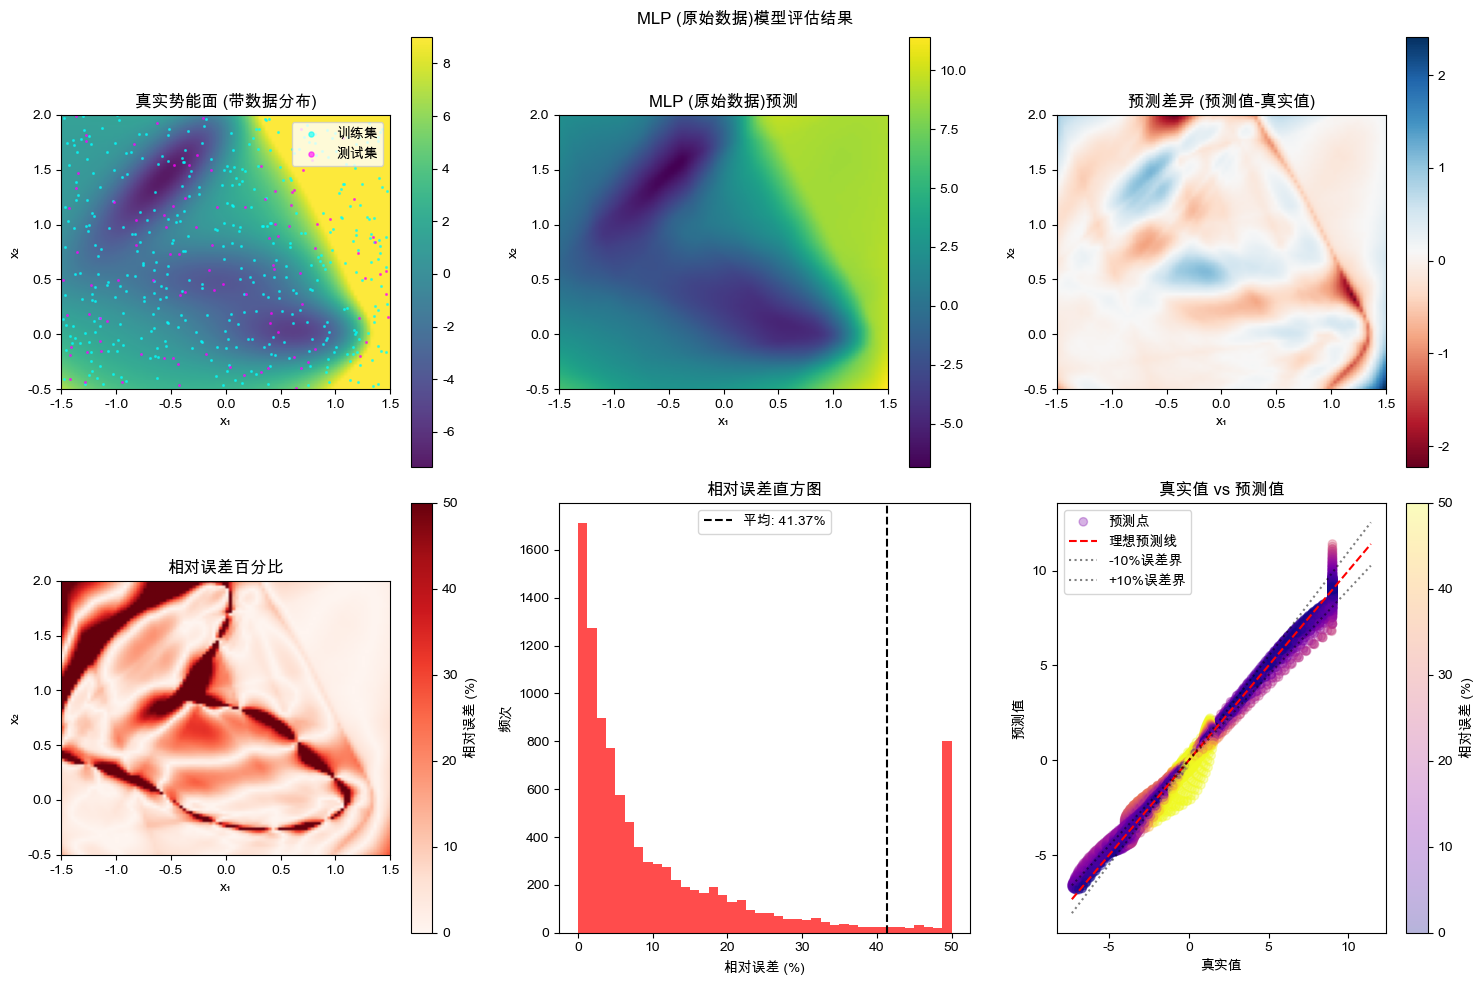


MLP (原始数据)评估指标:
全局MAE: 0.2503
训练集MAE: 0.1852
测试集MAE: 0.2095
RMSE: 0.3793
最大误差: 2.4097
平均相对误差: 41.37%

评估StdNet (第一轮)...
保存评估图像: results_20250330_150206/figures/StdNet_round1_评估结果.png


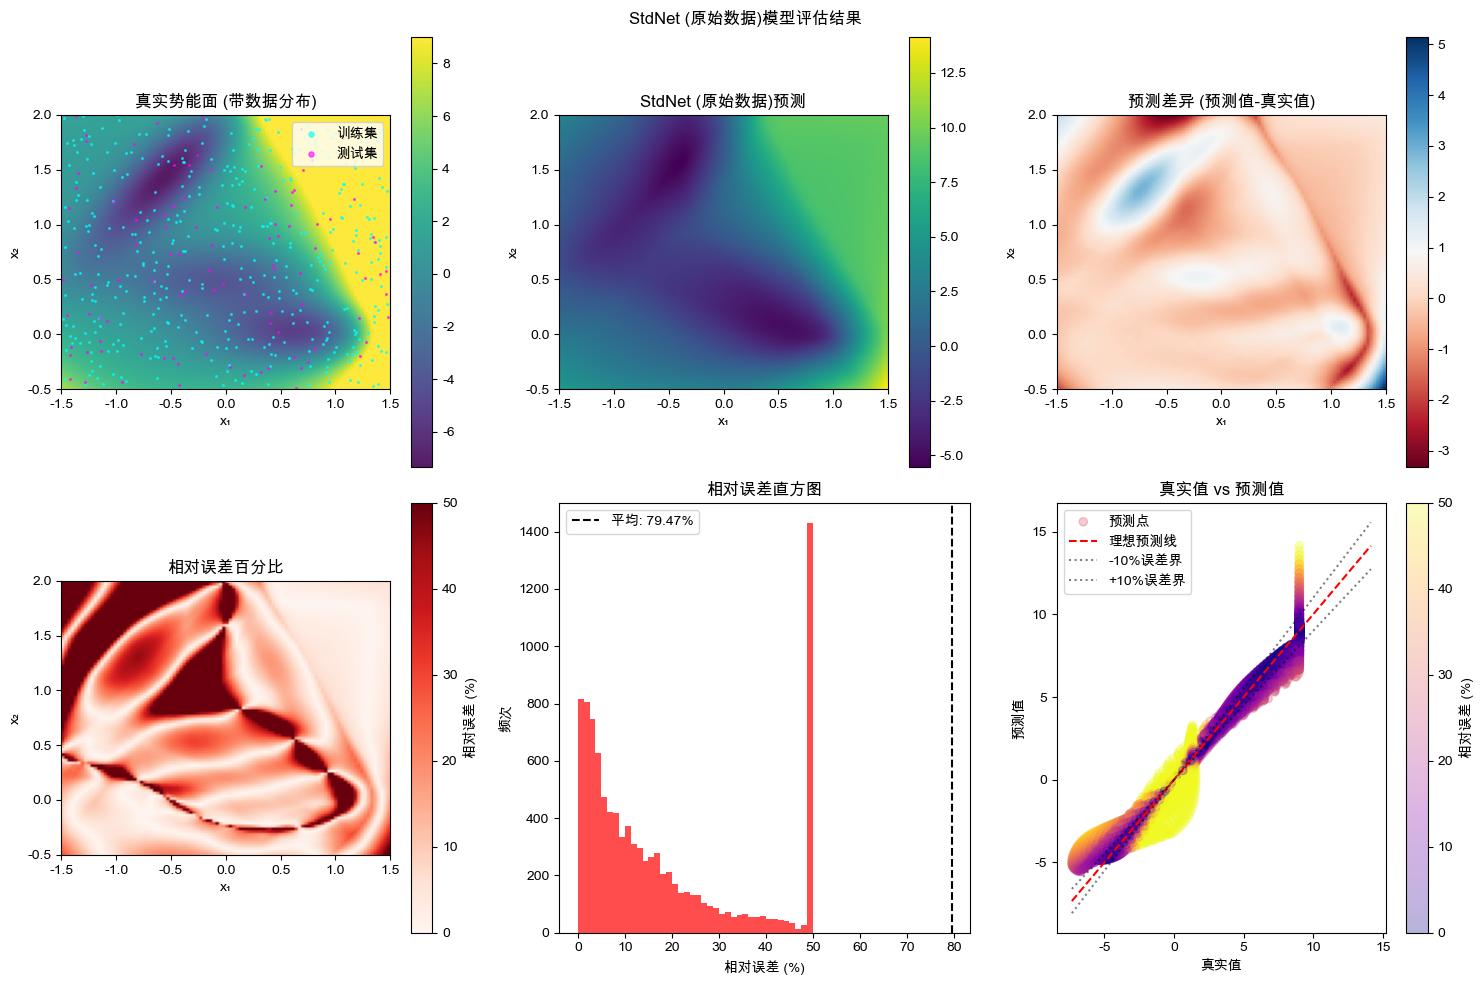


StdNet (原始数据)评估指标:
全局MAE: 0.4901
训练集MAE: 0.4008
测试集MAE: 0.4368
RMSE: 0.7310
最大误差: 5.1441
平均相对误差: 79.47%

评估ResNet (第一轮)...
保存评估图像: results_20250330_150206/figures/ResNet_round1_评估结果.png


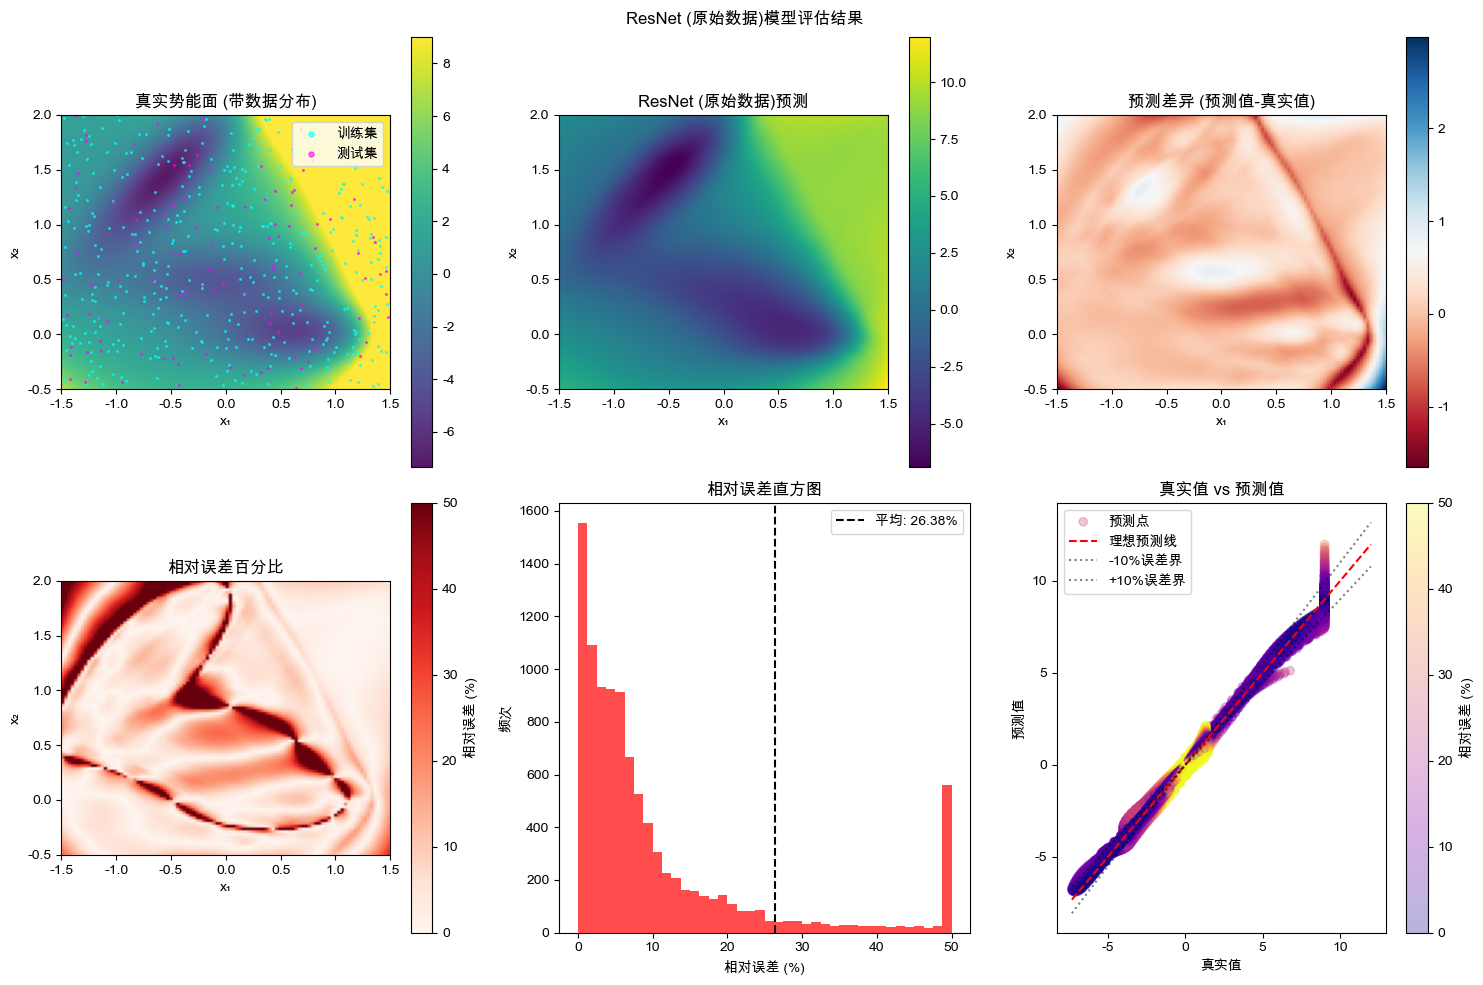


ResNet (原始数据)评估指标:
全局MAE: 0.2295
训练集MAE: 0.1774
测试集MAE: 0.2062
RMSE: 0.3431
最大误差: 2.9828
平均相对误差: 26.38%

第二轮训练: 使用增广数据点 (原始数据 + 2000个增广点)
从文件 train_data.txt 加载数据...
增广数据，额外添加 2000 个点...
数据增广后总样本数: 2500
增广后数据集总点数: 2500

训练MLP (第二轮)...
开始训练，设备: mps
Epoch   1 | Train Loss: 1.9665e+01 | Val Loss: 9.6749e+00 | LR: 1.00e-03 | Time: 0.12s
Epoch  10 | Train Loss: 1.4422e+00 | Val Loss: 1.3922e+00 | LR: 1.00e-03 | Time: 0.10s
Epoch  20 | Train Loss: 5.8474e-01 | Val Loss: 5.5680e-01 | LR: 1.00e-03 | Time: 0.09s
Epoch  30 | Train Loss: 2.4448e-01 | Val Loss: 3.5580e-01 | LR: 1.00e-03 | Time: 0.09s
Epoch  40 | Train Loss: 1.7129e-01 | Val Loss: 2.7719e-01 | LR: 1.00e-03 | Time: 0.09s
Epoch  50 | Train Loss: 1.1840e-01 | Val Loss: 2.0633e-01 | LR: 1.00e-03 | Time: 0.10s
Epoch  60 | Train Loss: 9.0136e-02 | Val Loss: 1.0776e-01 | LR: 1.00e-03 | Time: 0.09s
Epoch  70 | Train Loss: 7.3141e-02 | Val Loss: 9.9819e-02 | LR: 1.00e-03 | Time: 0.09s
Epoch  80 | Train Loss: 6.8663e-02 | Val Loss: 6.6379e-0

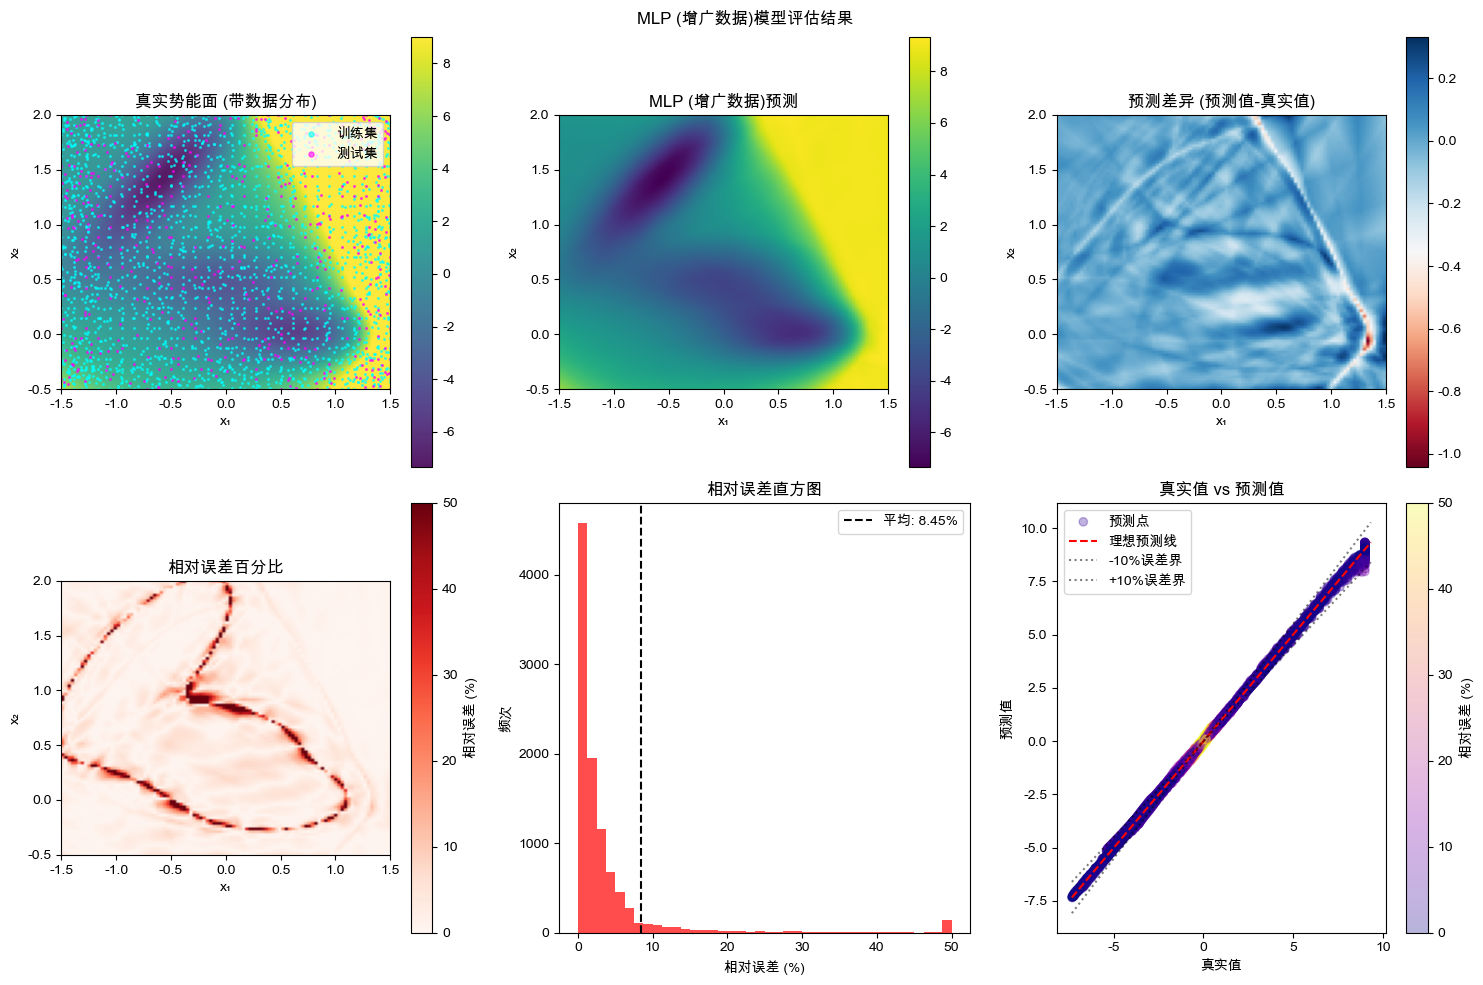


MLP (增广数据)评估指标:
全局MAE: 0.0568
训练集MAE: 0.0481
测试集MAE: 0.0578
RMSE: 0.0874
最大误差: 1.0415
平均相对误差: 8.45%

评估StdNet (第二轮)...
保存评估图像: results_20250330_150206/figures/StdNet_round2_评估结果.png


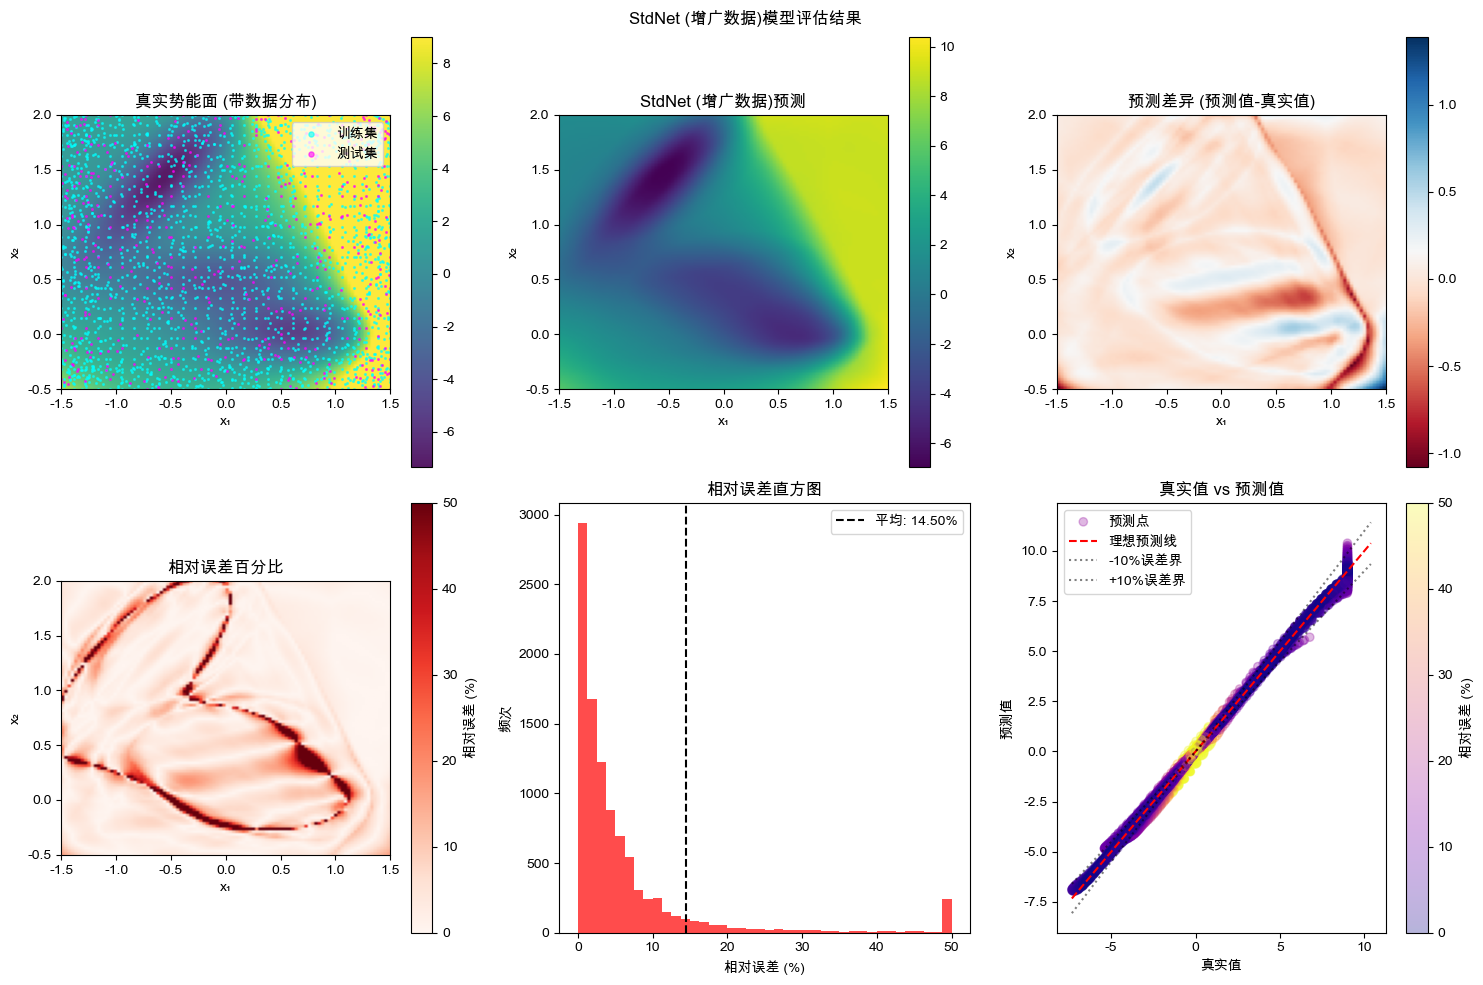


StdNet (增广数据)评估指标:
全局MAE: 0.1110
训练集MAE: 0.1019
测试集MAE: 0.1176
RMSE: 0.1748
最大误差: 1.3873
平均相对误差: 14.50%

评估ResNet (第二轮)...
保存评估图像: results_20250330_150206/figures/ResNet_round2_评估结果.png


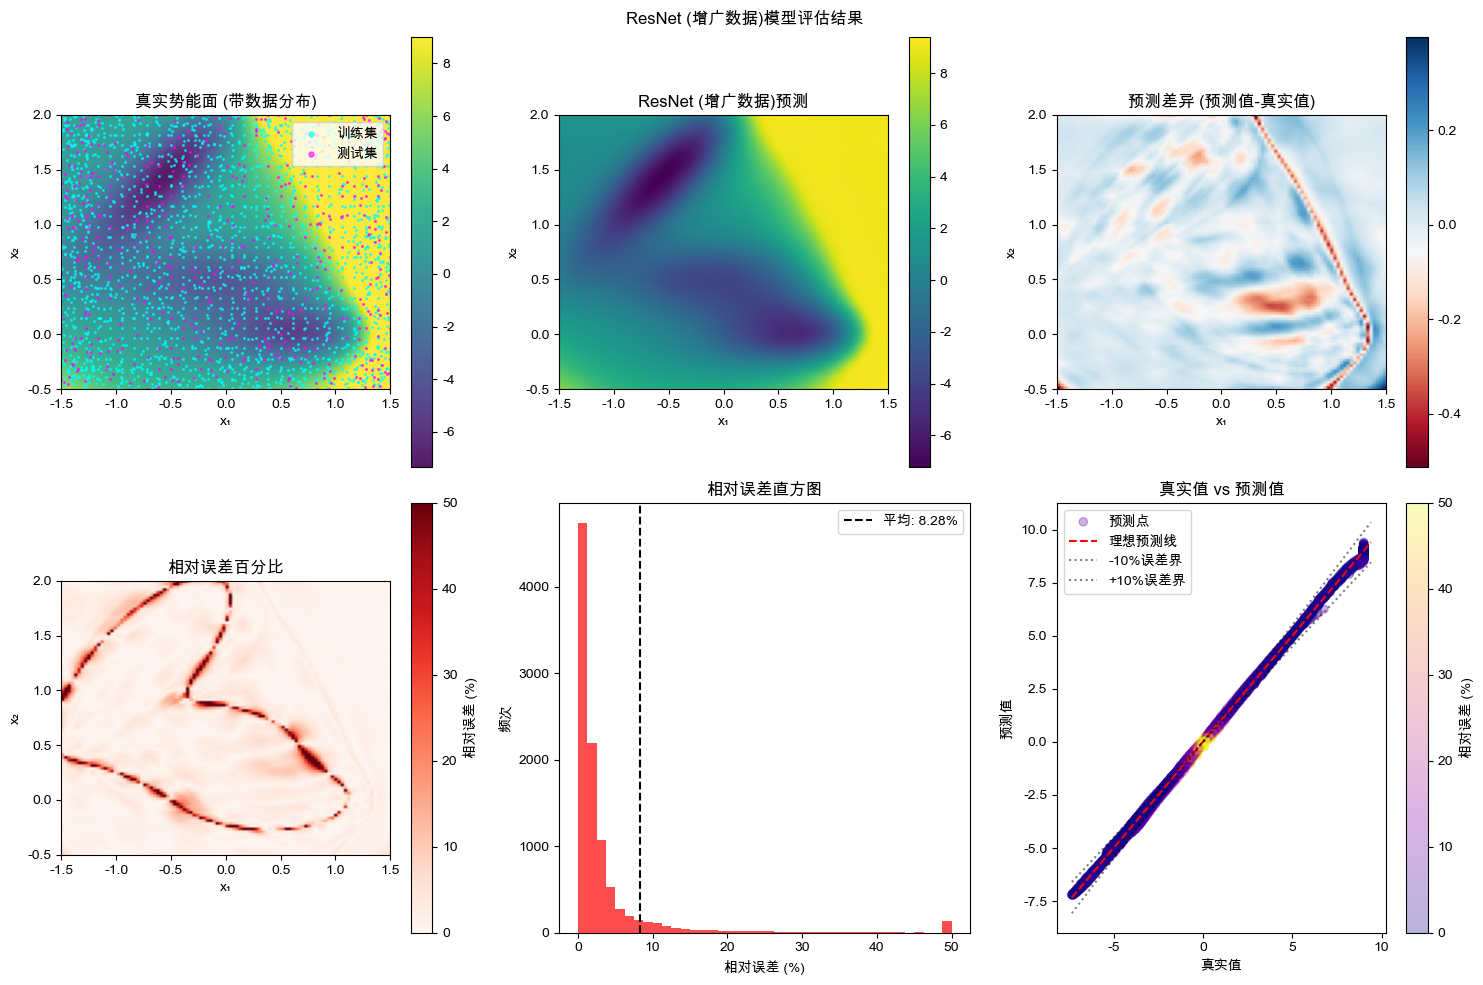


ResNet (增广数据)评估指标:
全局MAE: 0.0521
训练集MAE: 0.0452
测试集MAE: 0.0520
RMSE: 0.0766
最大误差: 0.5123
平均相对误差: 8.28%


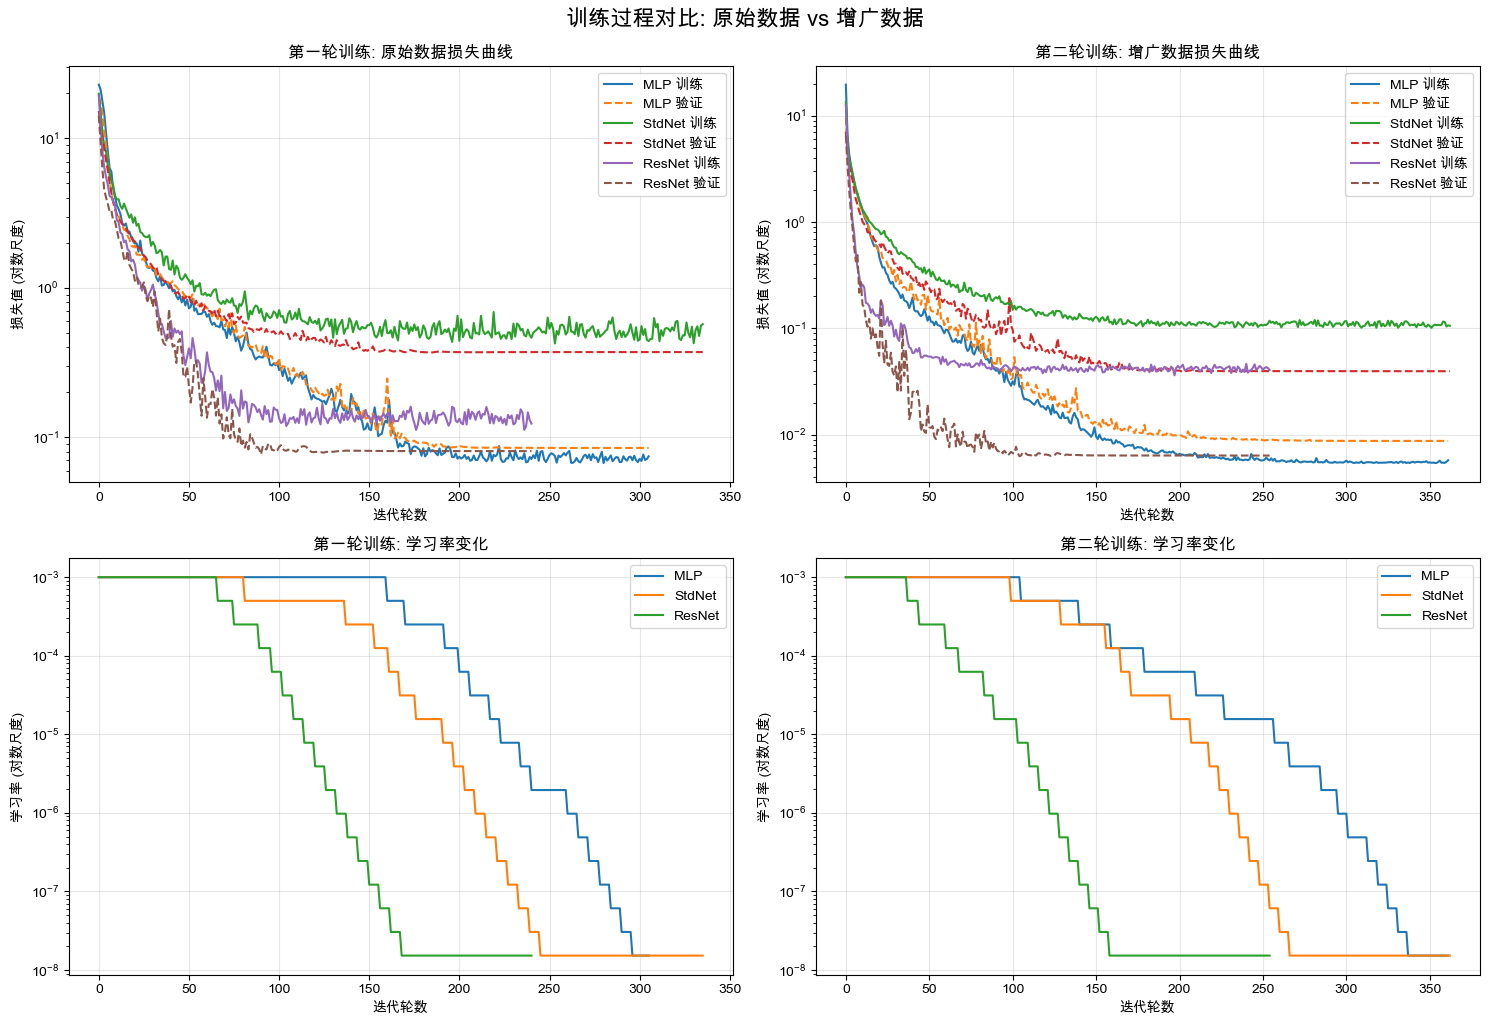

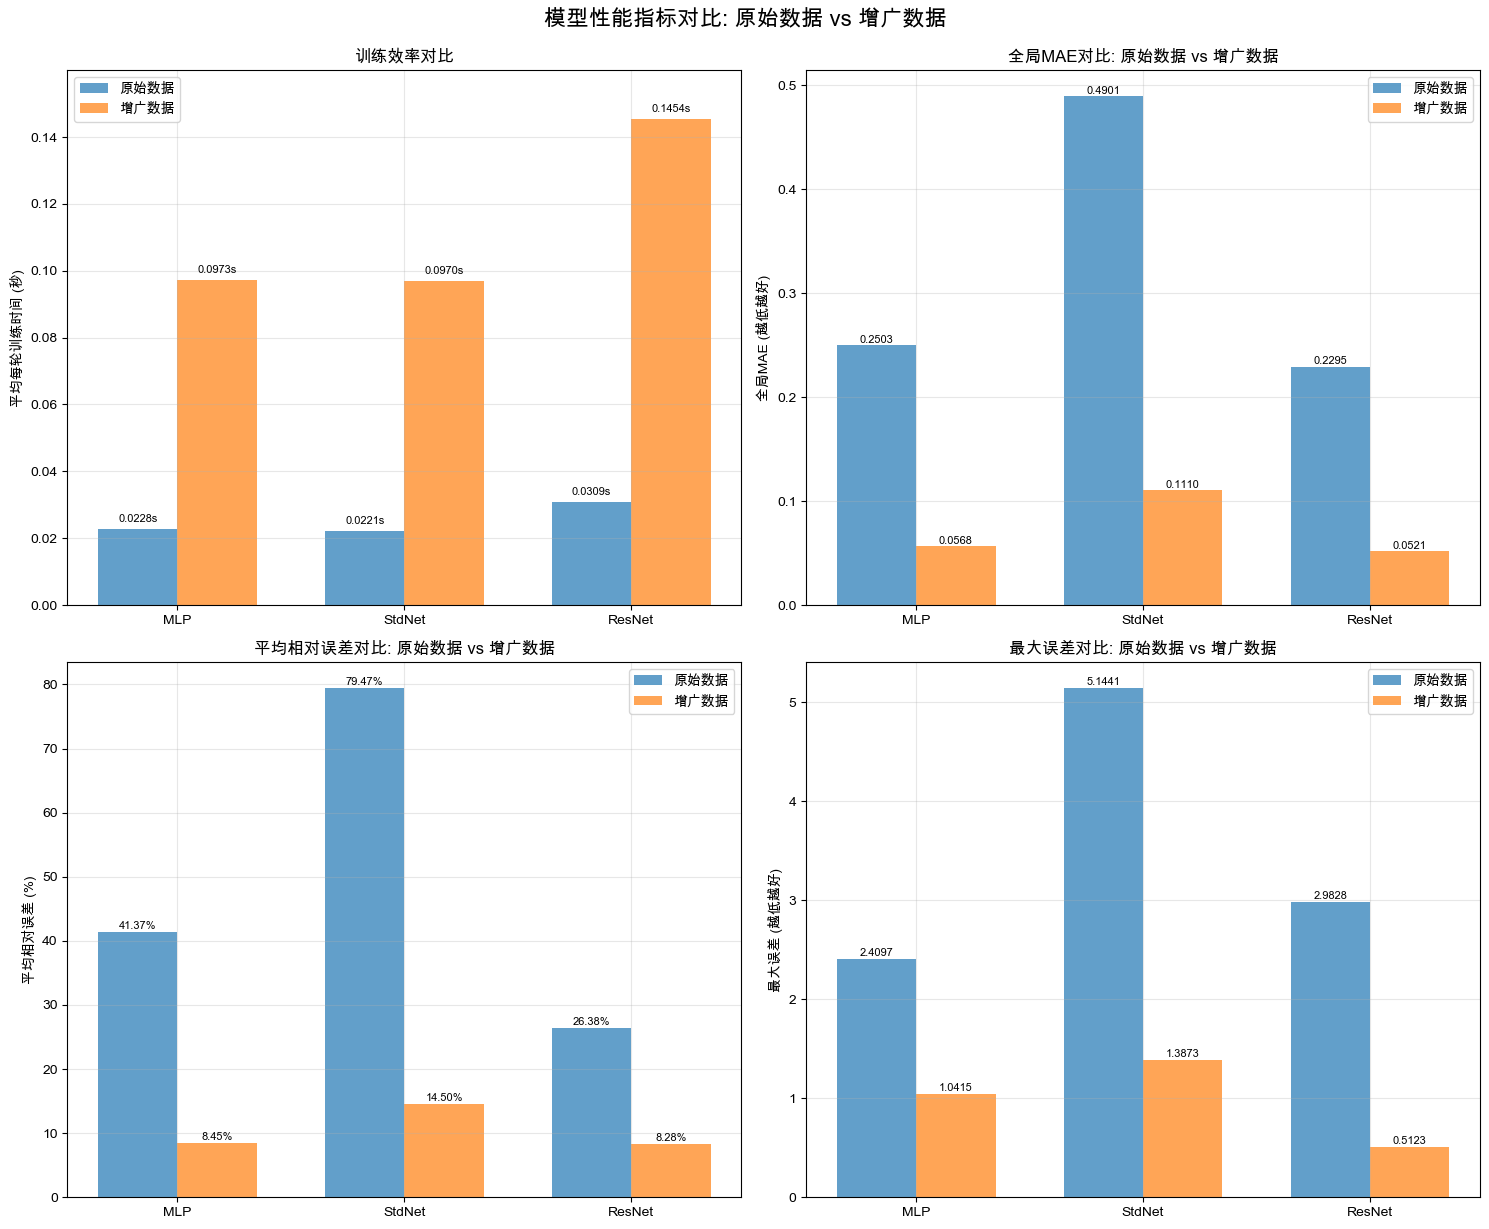

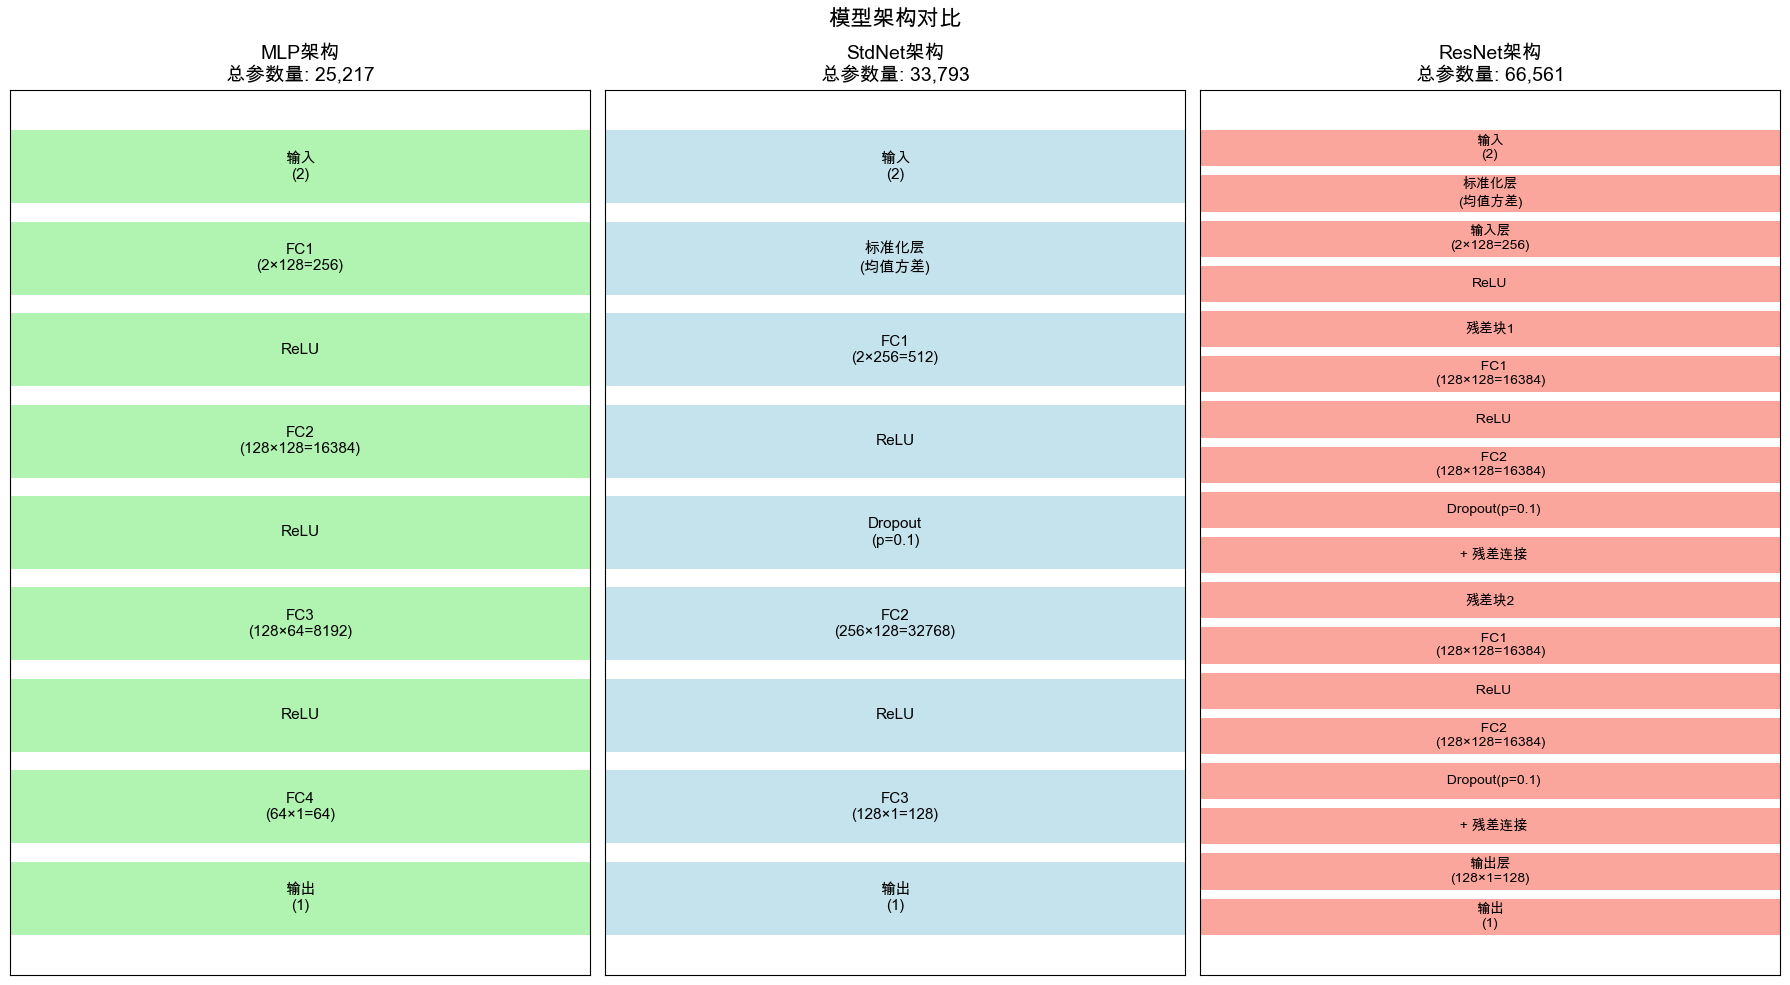


所有结果已保存到目录: results_20250330_150206
- 模型文件保存在: results_20250330_150206/models
- 图形文件保存在: results_20250330_150206/figures
- 对比报告: results_20250330_150206/模型对比报告.txt
- 训练历史数据: results_20250330_150206/训练历史数据.json


In [ ]:
def main():
    """主训练流程：执行两轮训练，分别使用不同数量的数据点"""

    # 设置随机种子
    torch.manual_seed(42)
    np.random.seed(42)

    # 创建结果保存目录
    result_dir = create_result_dir()

    # 训练参数
    criterion = nn.MSELoss()
    scheduler_kwargs = {"mode": "min", "factor": 0.5, "patience": 5}

    # 保存两轮训练的指标结果
    all_metrics = {}
    all_history = {}

    # ============================== 第一轮训练（原始数据）==============================
    print("\n" + "=" * 70)
    print(f"第一轮训练: 使用原始数据点 (无增广)")
    print("=" * 70)

    # 准备数据 - 第一轮使用原始数据点，不进行增广
    train_loader_1, val_loader_1, data_info_1 = prepare_data(
        data_file="train_data.txt", augment=False
    )

    # 获取数据点数量
    n_points_1 = len(data_info_1["X_train"]) + len(data_info_1["X_val"])
    print(f"数据集总点数: {n_points_1}")

    # 创建模型
    mlp_1 = MLP()
    stdnet_1 = StdNet(data_info_1["mean"], data_info_1["std"])
    resnet_1 = ResNet(data_info_1["mean"], data_info_1["std"])

    # 计算并打印模型参数量
    mlp_params = count_parameters(mlp_1)
    std_params = count_parameters(stdnet_1)
    res_params = count_parameters(resnet_1)
    print(f"MLP参数量: {mlp_params:,}")
    print(f"StdNet参数量: {std_params:,}")
    print(f"ResNet参数量: {res_params:,}")

    # 训练第一轮MLP
    print("\n训练MLP (第一轮)...")
    optimizer_mlp_1 = torch.optim.Adam(mlp_1.parameters(), lr=0.001)
    scheduler_mlp_1 = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer_mlp_1, **scheduler_kwargs
    )
    mlp_1, best_val_mlp_1, history_mlp_1 = train_model(
        mlp_1,
        train_loader_1,
        val_loader_1,
        criterion,
        optimizer_mlp_1,
        scheduler_mlp_1,
        patience=50,
        device=device,
    )

    # 训练第一轮StdNet
    print("\n训练StdNet (第一轮)...")
    optimizer_std_1 = torch.optim.Adam(stdnet_1.parameters(), lr=0.001)
    scheduler_std_1 = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer_std_1, **scheduler_kwargs
    )
    stdnet_1, best_val_std_1, history_std_1 = train_model(
        stdnet_1,
        train_loader_1,
        val_loader_1,
        criterion,
        optimizer_std_1,
        scheduler_std_1,
        patience=150,
        device=device,
    )

    # 训练第一轮ResNet
    print("\n训练ResNet (第一轮)...")
    optimizer_res_1 = torch.optim.Adam(resnet_1.parameters(), lr=0.001)
    scheduler_res_1 = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer_res_1, **scheduler_kwargs
    )
    resnet_1, best_val_res_1, history_res_1 = train_model(
        resnet_1,
        train_loader_1,
        val_loader_1,
        criterion,
        optimizer_res_1,
        scheduler_res_1,
        patience=150,
        device=device,
    )

    # 生成时间戳
    timestamp_1 = get_timestamp()

    # 保存第一轮训练的模型（使用时间戳）
    model_dir = os.path.join(result_dir, "models")
    torch.save(
        mlp_1.state_dict(),
        os.path.join(model_dir, f"mlp_data{n_points_1}_{timestamp_1}.pth"),
    )
    torch.save(
        stdnet_1.state_dict(),
        os.path.join(model_dir, f"stdnet_data{n_points_1}_{timestamp_1}.pth"),
    )
    torch.save(
        resnet_1.state_dict(),
        os.path.join(model_dir, f"resnet_data{n_points_1}_{timestamp_1}.pth"),
    )

    # 评估第一轮模型
    print("\n评估MLP (第一轮)...")
    metrics_mlp_1 = evaluate_and_visualize(
        mlp_1,
        data_info_1,
        "MLP (原始数据)",
        device=device,
        result_dir=result_dir,
        round_name="round1",
    )

    print("\n评估StdNet (第一轮)...")
    metrics_std_1 = evaluate_and_visualize(
        stdnet_1,
        data_info_1,
        "StdNet (原始数据)",
        device=device,
        result_dir=result_dir,
        round_name="round1",
    )

    print("\n评估ResNet (第一轮)...")
    metrics_res_1 = evaluate_and_visualize(
        resnet_1,
        data_info_1,
        "ResNet (原始数据)",
        device=device,
        result_dir=result_dir,
        round_name="round1",
    )

    # 保存第一轮训练的历史和指标
    all_history["round1"] = {
        "MLP": history_mlp_1,
        "StdNet": history_std_1,
        "ResNet": history_res_1,
    }

    all_metrics["round1"] = {
        "MLP": metrics_mlp_1,
        "StdNet": metrics_std_1,
        "ResNet": metrics_res_1,
    }

    # ============================== 第二轮训练（增广数据）==============================
    print("\n" + "=" * 70)
    print(f"第二轮训练: 使用增广数据点 (原始数据 + 2000个增广点)")
    print("=" * 70)

    # 准备数据 - 第二轮使用增广数据
    train_loader_2, val_loader_2, data_info_2 = prepare_data(
        data_file="train_data.txt", augment=True, n_augment=2000
    )

    # 获取数据点数量
    n_points_2 = len(data_info_2["X_train"]) + len(data_info_2["X_val"])
    print(f"增广后数据集总点数: {n_points_2}")

    # 创建模型
    mlp_2 = MLP()
    stdnet_2 = StdNet(data_info_2["mean"], data_info_2["std"])
    resnet_2 = ResNet(data_info_2["mean"], data_info_2["std"])

    # 训练第二轮MLP
    print("\n训练MLP (第二轮)...")
    optimizer_mlp_2 = torch.optim.Adam(mlp_2.parameters(), lr=0.001)
    scheduler_mlp_2 = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer_mlp_2, **scheduler_kwargs
    )
    mlp_2, best_val_mlp_2, history_mlp_2 = train_model(
        mlp_2,
        train_loader_2,
        val_loader_2,
        criterion,
        optimizer_mlp_2,
        scheduler_mlp_2,
        patience=50,
        device=device,
    )

    # 训练第二轮StdNet
    print("\n训练StdNet (第二轮)...")
    optimizer_std_2 = torch.optim.Adam(stdnet_2.parameters(), lr=0.001)
    scheduler_std_2 = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer_std_2, **scheduler_kwargs
    )
    stdnet_2, best_val_std_2, history_std_2 = train_model(
        stdnet_2,
        train_loader_2,
        val_loader_2,
        criterion,
        optimizer_std_2,
        scheduler_std_2,
        patience=150,
        device=device,
    )

    # 训练第二轮ResNet
    print("\n训练ResNet (第二轮)...")
    optimizer_res_2 = torch.optim.Adam(resnet_2.parameters(), lr=0.001)
    scheduler_res_2 = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer_res_2, **scheduler_kwargs
    )
    resnet_2, best_val_res_2, history_res_2 = train_model(
        resnet_2,
        train_loader_2,
        val_loader_2,
        criterion,
        optimizer_res_2,
        scheduler_res_2,
        patience=150,
        device=device,
    )

    # 生成时间戳
    timestamp_2 = get_timestamp()

    # 保存第二轮训练的模型（使用时间戳）
    torch.save(
        mlp_2.state_dict(),
        os.path.join(model_dir, f"mlp_data{n_points_2}_{timestamp_2}.pth"),
    )
    torch.save(
        stdnet_2.state_dict(),
        os.path.join(model_dir, f"stdnet_data{n_points_2}_{timestamp_2}.pth"),
    )
    torch.save(
        resnet_2.state_dict(),
        os.path.join(model_dir, f"resnet_data{n_points_2}_{timestamp_2}.pth"),
    )

    # 评估第二轮模型
    print("\n评估MLP (第二轮)...")
    metrics_mlp_2 = evaluate_and_visualize(
        mlp_2,
        data_info_2,
        "MLP (增广数据)",
        device=device,
        result_dir=result_dir,
        round_name="round2",
    )

    print("\n评估StdNet (第二轮)...")
    metrics_std_2 = evaluate_and_visualize(
        stdnet_2,
        data_info_2,
        "StdNet (增广数据)",
        device=device,
        result_dir=result_dir,
        round_name="round2",
    )

    print("\n评估ResNet (第二轮)...")
    metrics_res_2 = evaluate_and_visualize(
        resnet_2,
        data_info_2,
        "ResNet (增广数据)",
        device=device,
        result_dir=result_dir,
        round_name="round2",
    )

    # 保存第二轮训练的历史和指标
    all_history["round2"] = {
        "MLP": history_mlp_2,
        "StdNet": history_std_2,
        "ResNet": history_res_2,
    }

    all_metrics["round2"] = {
        "MLP": metrics_mlp_2,
        "StdNet": metrics_std_2,
        "ResNet": metrics_res_2,
    }

    # ============================== 可视化训练过程和对比结果 ==============================

    # 创建多个分页的图表，以便更清晰地展示结果
    # 第一页：训练损失和验证损失对比
    plt.figure(figsize=(15, 10))

    # 第一轮训练的损失曲线
    plt.subplot(221)
    plt.plot(all_history["round1"]["MLP"]["train_loss"], label="MLP 训练")
    plt.plot(all_history["round1"]["MLP"]["val_loss"], linestyle="--", label="MLP 验证")
    plt.plot(all_history["round1"]["StdNet"]["train_loss"], label="StdNet 训练")
    plt.plot(
        all_history["round1"]["StdNet"]["val_loss"], linestyle="--", label="StdNet 验证"
    )
    plt.plot(all_history["round1"]["ResNet"]["train_loss"], label="ResNet 训练")
    plt.plot(
        all_history["round1"]["ResNet"]["val_loss"], linestyle="--", label="ResNet 验证"
    )
    plt.yscale("log")  # 使用对数尺度更好地显示损失曲线
    plt.xlabel("迭代轮数")
    plt.ylabel("损失值 (对数尺度)")
    plt.title("第一轮训练: 原始数据损失曲线")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 第二轮训练的损失曲线
    plt.subplot(222)
    plt.plot(all_history["round2"]["MLP"]["train_loss"], label="MLP 训练")
    plt.plot(all_history["round2"]["MLP"]["val_loss"], linestyle="--", label="MLP 验证")
    plt.plot(all_history["round2"]["StdNet"]["train_loss"], label="StdNet 训练")
    plt.plot(
        all_history["round2"]["StdNet"]["val_loss"], linestyle="--", label="StdNet 验证"
    )
    plt.plot(all_history["round2"]["ResNet"]["train_loss"], label="ResNet 训练")
    plt.plot(
        all_history["round2"]["ResNet"]["val_loss"], linestyle="--", label="ResNet 验证"
    )
    plt.yscale("log")  # 使用对数尺度更好地显示损失曲线
    plt.xlabel("迭代轮数")
    plt.ylabel("损失值 (对数尺度)")
    plt.title("第二轮训练: 增广数据损失曲线")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 学习率变化对比 (第一轮)
    plt.subplot(223)
    plt.plot(all_history["round1"]["MLP"]["lr"], label="MLP")
    plt.plot(all_history["round1"]["StdNet"]["lr"], label="StdNet")
    plt.plot(all_history["round1"]["ResNet"]["lr"], label="ResNet")
    plt.yscale("log")  # 对数尺度
    plt.xlabel("迭代轮数")
    plt.ylabel("学习率 (对数尺度)")
    plt.title("第一轮训练: 学习率变化")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 学习率变化对比 (第二轮)
    plt.subplot(224)
    plt.plot(all_history["round2"]["MLP"]["lr"], label="MLP")
    plt.plot(all_history["round2"]["StdNet"]["lr"], label="StdNet")
    plt.plot(all_history["round2"]["ResNet"]["lr"], label="ResNet")
    plt.yscale("log")  # 对数尺度
    plt.xlabel("迭代轮数")
    plt.ylabel("学习率 (对数尺度)")
    plt.title("第二轮训练: 学习率变化")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.suptitle("训练过程对比: 原始数据 vs 增广数据", y=1.02, fontsize=16)

    # 保存训练过程对比图
    plt.savefig(
        os.path.join(result_dir, "figures", "训练过程对比.png"),
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

    # 第二页：训练效率和性能指标对比
    plt.figure(figsize=(15, 12))

    # 训练效率对比 - 使用对数尺度或调整y轴范围
    plt.subplot(221)
    models = ["MLP", "StdNet", "ResNet"]
    # 计算各个模型在两轮训练中的平均每轮训练时间
    avg_times_1 = [
        np.mean(all_history["round1"]["MLP"]["epoch_times"]),
        np.mean(all_history["round1"]["StdNet"]["epoch_times"]),
        np.mean(all_history["round1"]["ResNet"]["epoch_times"]),
    ]
    avg_times_2 = [
        np.mean(all_history["round2"]["MLP"]["epoch_times"]),
        np.mean(all_history["round2"]["StdNet"]["epoch_times"]),
        np.mean(all_history["round2"]["ResNet"]["epoch_times"]),
    ]

    x = np.arange(len(models))
    width = 0.35

    # 调整y轴最大值以确保所有柱子可见
    max_time = max(max(avg_times_1), max(avg_times_2))

    bars1 = plt.bar(x - width / 2, avg_times_1, width, label="原始数据", alpha=0.7)
    bars2 = plt.bar(x + width / 2, avg_times_2, width, label="增广数据", alpha=0.7)

    plt.ylabel("平均每轮训练时间 (秒)")
    plt.title("训练效率对比")
    plt.xticks(x, models)
    plt.ylim(0, max_time * 1.1)  # 设置y轴上限为最大值的1.1倍
    plt.legend()

    # 添加具体数值标签
    for i, bars in enumerate([bars1, bars2]):
        for bar in bars:
            height = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2.0,
                height + max_time * 0.01,
                f"{height:.4f}s",
                ha="center",
                va="bottom",
                fontsize=8,
            )
    plt.grid(True, alpha=0.3)

    # 两轮训练的MAE对比
    plt.subplot(222)
    metrics_names = ["全局MAE", "RMSE", "最大误差", "平均相对误差(%)"]
    mae_1 = [
        all_metrics["round1"]["MLP"]["全局MAE"],
        all_metrics["round1"]["StdNet"]["全局MAE"],
        all_metrics["round1"]["ResNet"]["全局MAE"],
    ]
    mae_2 = [
        all_metrics["round2"]["MLP"]["全局MAE"],
        all_metrics["round2"]["StdNet"]["全局MAE"],
        all_metrics["round2"]["ResNet"]["全局MAE"],
    ]

    bars1 = plt.bar(x - width / 2, mae_1, width, label="原始数据", alpha=0.7)
    bars2 = plt.bar(x + width / 2, mae_2, width, label="增广数据", alpha=0.7)

    plt.ylabel("全局MAE (越低越好)")
    plt.title("全局MAE对比: 原始数据 vs 增广数据")
    plt.xticks(x, models)
    plt.legend()

    # 添加具体数值标签
    for bar in bars1:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + 0.0001,
            f"{height:.4f}",
            ha="center",
            va="bottom",
            fontsize=8,
        )
    for bar in bars2:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + 0.0001,
            f"{height:.4f}",
            ha="center",
            va="bottom",
            fontsize=8,
        )
    plt.grid(True, alpha=0.3)

    # 平均相对误差对比
    plt.subplot(223)
    rel_err_1 = [
        all_metrics["round1"]["MLP"]["平均相对误差(%)"],
        all_metrics["round1"]["StdNet"]["平均相对误差(%)"],
        all_metrics["round1"]["ResNet"]["平均相对误差(%)"],
    ]
    rel_err_2 = [
        all_metrics["round2"]["MLP"]["平均相对误差(%)"],
        all_metrics["round2"]["StdNet"]["平均相对误差(%)"],
        all_metrics["round2"]["ResNet"]["平均相对误差(%)"],
    ]

    bars1 = plt.bar(x - width / 2, rel_err_1, width, label="原始数据", alpha=0.7)
    bars2 = plt.bar(x + width / 2, rel_err_2, width, label="增广数据", alpha=0.7)

    plt.ylabel("平均相对误差 (%)")
    plt.title("平均相对误差对比: 原始数据 vs 增广数据")
    plt.xticks(x, models)
    plt.legend()

    # 添加具体数值标签
    for bar in bars1:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + 0.2,
            f"{height:.2f}%",
            ha="center",
            va="bottom",
            fontsize=8,
        )
    for bar in bars2:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + 0.2,
            f"{height:.2f}%",
            ha="center",
            va="bottom",
            fontsize=8,
        )
    plt.grid(True, alpha=0.3)

    # 最大误差对比
    plt.subplot(224)
    max_err_1 = [
        all_metrics["round1"]["MLP"]["最大误差"],
        all_metrics["round1"]["StdNet"]["最大误差"],
        all_metrics["round1"]["ResNet"]["最大误差"],
    ]
    max_err_2 = [
        all_metrics["round2"]["MLP"]["最大误差"],
        all_metrics["round2"]["StdNet"]["最大误差"],
        all_metrics["round2"]["ResNet"]["最大误差"],
    ]

    bars1 = plt.bar(x - width / 2, max_err_1, width, label="原始数据", alpha=0.7)
    bars2 = plt.bar(x + width / 2, max_err_2, width, label="增广数据", alpha=0.7)

    plt.ylabel("最大误差 (越低越好)")
    plt.title("最大误差对比: 原始数据 vs 增广数据")
    plt.xticks(x, models)
    plt.legend()

    # 添加具体数值标签
    for bar in bars1:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + 0.01,
            f"{height:.4f}",
            ha="center",
            va="bottom",
            fontsize=8,
        )
    for bar in bars2:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + 0.01,
            f"{height:.4f}",
            ha="center",
            va="bottom",
            fontsize=8,
        )
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.suptitle("模型性能指标对比: 原始数据 vs 增广数据", y=1.02, fontsize=16)

    # 保存性能指标对比图
    plt.savefig(
        os.path.join(result_dir, "figures", "性能指标对比.png"),
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

    # 第三页：架构对比图（保持不变，但添加更清晰的标题）
    plt.figure(figsize=(18, 10))

    # MLP架构图
    plt.subplot(131)
    mlp_layers = [
        "输入\n(2)",
        f"FC1\n(2×128={2*128})",
        "ReLU",
        f"FC2\n(128×128={128*128})",
        "ReLU",
        f"FC3\n(128×64={128*64})",
        "ReLU",
        f"FC4\n(64×1={64*1})",
        "输出\n(1)",
    ]
    positions = range(len(mlp_layers))
    plt.barh(positions, [0.7] * len(positions), color="lightgreen", alpha=0.7)

    for i, (pos, layer) in enumerate(zip(positions, mlp_layers)):
        plt.text(
            0.35, pos, layer, ha="center", va="center", fontsize=11, fontweight="bold"
        )

    plt.yticks([])
    plt.xticks([])
    plt.xlim([0, 0.7])
    plt.title(f"MLP架构\n总参数量: {mlp_params:,}", fontsize=14)
    plt.gca().invert_yaxis()

    # StdNet架构图
    plt.subplot(132)
    stdnet_layers = [
        "输入\n(2)",
        "标准化层\n(均值方差)",
        f"FC1\n(2×256={2*256})",
        "ReLU",
        "Dropout\n(p=0.1)",
        f"FC2\n(256×128={256*128})",
        "ReLU",
        f"FC3\n(128×1={128*1})",
        "输出\n(1)",
    ]
    positions = range(len(stdnet_layers))
    plt.barh(positions, [0.7] * len(positions), color="lightblue", alpha=0.7)

    for i, (pos, layer) in enumerate(zip(positions, stdnet_layers)):
        plt.text(
            0.35, pos, layer, ha="center", va="center", fontsize=11, fontweight="bold"
        )

    plt.yticks([])
    plt.xticks([])
    plt.xlim([0, 0.7])
    plt.title(f"StdNet架构\n总参数量: {std_params:,}", fontsize=14)
    plt.gca().invert_yaxis()

    # ResNet架构图
    plt.subplot(133)
    resnet_layers = [
        "输入\n(2)",
        "标准化层\n(均值方差)",
        f"输入层\n(2×128={2*128})",
        "ReLU",
        "残差块1",
        f"  FC1\n(128×128={128*128})",
        "  ReLU",
        f"  FC2\n(128×128={128*128})",
        "  Dropout(p=0.1)",
        "  + 残差连接",
        "残差块2",
        f"  FC1\n(128×128={128*128})",
        "  ReLU",
        f"  FC2\n(128×128={128*128})",
        "  Dropout(p=0.1)",
        "  + 残差连接",
        f"输出层\n(128×1={128*1})",
        "输出\n(1)",
    ]
    positions = range(len(resnet_layers))
    plt.barh(positions, [0.7] * len(positions), color="salmon", alpha=0.7)

    for i, (pos, layer) in enumerate(zip(positions, resnet_layers)):
        plt.text(
            0.35, pos, layer, ha="center", va="center", fontsize=10, fontweight="bold"
        )

    plt.yticks([])
    plt.xticks([])
    plt.xlim([0, 0.7])
    plt.title(f"ResNet架构\n总参数量: {res_params:,}", fontsize=14)
    plt.gca().invert_yaxis()

    plt.tight_layout()
    plt.suptitle("模型架构对比", y=0.98, fontsize=16, fontweight="bold")
    plt.subplots_adjust(top=0.9)

    # 保存模型架构对比图
    plt.savefig(
        os.path.join(result_dir, "figures", "模型架构对比.png"),
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

    # 保存详细比较报告到文本文件
    report_file = os.path.join(result_dir, "模型对比报告.txt")
    with open(report_file, "w", encoding="utf-8") as f:
        f.write("=" * 70 + "\n")
        f.write("模型对比详细报告：原始数据 vs 增广数据".center(60) + "\n")
        f.write("=" * 70 + "\n\n")

        # 创建表格格式
        format_row = "{:20} | {:^15} | {:^15} | {:^15}\n"
        f.write(format_row.format("指标", "MLP", "StdNet", "ResNet"))
        f.write("-" * 68 + "\n")

        # 模型基本信息
        f.write(
            format_row.format(
                "模型参数量", f"{mlp_params:,}", f"{std_params:,}", f"{res_params:,}"
            )
        )
        f.write(format_row.format("标准化层", "否", "是", "是"))
        f.write(format_row.format("Dropout正则化", "否", "是", "是"))
        f.write(format_row.format("残差连接", "否", "否", "是"))

        # 按照两轮训练分别输出结果
        f.write("\n[第一轮训练 - 原始数据]\n")

        # 训练信息
        f.write(
            format_row.format(
                "训练轮数",
                len(all_history["round1"]["MLP"]["train_loss"]),
                len(all_history["round1"]["StdNet"]["train_loss"]),
                len(all_history["round1"]["ResNet"]["train_loss"]),
            )
        )
        total_time_mlp_1 = sum(all_history["round1"]["MLP"]["epoch_times"])
        total_time_std_1 = sum(all_history["round1"]["StdNet"]["epoch_times"])
        total_time_res_1 = sum(all_history["round1"]["ResNet"]["epoch_times"])
        f.write(
            format_row.format(
                "总训练时间(秒)",
                f"{total_time_mlp_1:.2f}",
                f"{total_time_std_1:.2f}",
                f"{total_time_res_1:.2f}",
            )
        )
        f.write(
            format_row.format(
                "平均每轮时间(秒)",
                f"{np.mean(all_history['round1']['MLP']['epoch_times']):.4f}",
                f"{np.mean(all_history['round1']['StdNet']['epoch_times']):.4f}",
                f"{np.mean(all_history['round1']['ResNet']['epoch_times']):.4f}",
            )
        )
        f.write(
            format_row.format(
                "最终学习率",
                f"{all_history['round1']['MLP']['lr'][-1]:.2e}",
                f"{all_history['round1']['StdNet']['lr'][-1]:.2e}",
                f"{all_history['round1']['ResNet']['lr'][-1]:.2e}",
            )
        )

        # 性能指标
        report_metrics = [
            "全局MAE",
            "训练集MAE",
            "测试集MAE",
            "RMSE",
            "最大误差",
            "平均相对误差(%)",
        ]
        for metric in report_metrics:
            f.write(
                format_row.format(
                    metric,
                    f"{all_metrics['round1']['MLP'][metric]:.4f}",
                    f"{all_metrics['round1']['StdNet'][metric]:.4f}",
                    f"{all_metrics['round1']['ResNet'][metric]:.4f}",
                )
            )

        # 第二轮结果
        f.write("\n[第二轮训练 - 增广数据]\n")

        # 训练信息
        f.write(
            format_row.format(
                "训练轮数",
                len(all_history["round2"]["MLP"]["train_loss"]),
                len(all_history["round2"]["StdNet"]["train_loss"]),
                len(all_history["round2"]["ResNet"]["train_loss"]),
            )
        )
        total_time_mlp_2 = sum(all_history["round2"]["MLP"]["epoch_times"])
        total_time_std_2 = sum(all_history["round2"]["StdNet"]["epoch_times"])
        total_time_res_2 = sum(all_history["round2"]["ResNet"]["epoch_times"])
        f.write(
            format_row.format(
                "总训练时间(秒)",
                f"{total_time_mlp_2:.2f}",
                f"{total_time_std_2:.2f}",
                f"{total_time_res_2:.2f}",
            )
        )
        f.write(
            format_row.format(
                "平均每轮时间(秒)",
                f"{np.mean(all_history['round2']['MLP']['epoch_times']):.4f}",
                f"{np.mean(all_history['round2']['StdNet']['epoch_times']):.4f}",
                f"{np.mean(all_history['round2']['ResNet']['epoch_times']):.4f}",
            )
        )
        f.write(
            format_row.format(
                "最终学习率",
                f"{all_history['round2']['MLP']['lr'][-1]:.2e}",
                f"{all_history['round2']['StdNet']['lr'][-1]:.2e}",
                f"{all_history['round2']['ResNet']['lr'][-1]:.2e}",
            )
        )

        # 性能指标
        for metric in report_metrics:
            f.write(
                format_row.format(
                    metric,
                    f"{all_metrics['round2']['MLP'][metric]:.4f}",
                    f"{all_metrics['round2']['StdNet'][metric]:.4f}",
                    f"{all_metrics['round2']['ResNet'][metric]:.4f}",
                )
            )

        # 改进百分比分析
        f.write("\n[数据增广带来的性能改进]\n")
        for model in ["MLP", "StdNet", "ResNet"]:
            mae_improve = (
                (
                    all_metrics["round1"][model]["全局MAE"]
                    - all_metrics["round2"][model]["全局MAE"]
                )
                / all_metrics["round1"][model]["全局MAE"]
                * 100
            )
            rel_err_improve = (
                (
                    all_metrics["round1"][model]["平均相对误差(%)"]
                    - all_metrics["round2"][model]["平均相对误差(%)"]
                )
                / all_metrics["round1"][model]["平均相对误差(%)"]
                * 100
            )
            f.write(
                f"{model}: 全局MAE改进 {mae_improve:.2f}%, 相对误差改进 {rel_err_improve:.2f}%\n"
            )

    # 将训练历史数据保存为JSON
    history_file = os.path.join(result_dir, "训练历史数据.json")

    # 转换NumPy数组和其他不可JSON序列化的对象
    def convert_for_json(obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, np.float32) or isinstance(obj, np.float64):
            return float(obj)
        elif isinstance(obj, np.int32) or isinstance(obj, np.int64):
            return int(obj)
        else:
            return obj

    # 准备要保存的数据
    json_data = {
        "all_metrics": all_metrics,
        "all_history": all_history,
        "timestamps": {
            "round1": timestamp_1,
            "round2": timestamp_2,
        },
        "model_params": {
            "MLP": mlp_params,
            "StdNet": std_params,
            "ResNet": res_params,
        },
        "data_points": {
            "round1": n_points_1,
            "round2": n_points_2,
        },
    }

    # 递归转换数据结构中的不可序列化对象
    def convert_nested_dict(d):
        for k, v in d.items():
            if isinstance(v, dict):
                convert_nested_dict(v)
            else:
                d[k] = convert_for_json(v)
        return d

    json_data = convert_nested_dict(json_data)

    # 保存为JSON文件
    with open(history_file, "w", encoding="utf-8") as f:
        json.dump(json_data, f, ensure_ascii=False, indent=2)

    print(f"\n所有结果已保存到目录: {result_dir}")
    print(f"- 模型文件保存在: {os.path.join(result_dir, 'models')}")
    print(f"- 图形文件保存在: {os.path.join(result_dir, 'figures')}")
    print(f"- 对比报告: {report_file}")
    print(f"- 训练历史数据: {history_file}")


if __name__ == "__main__":
    main()